In [1]:
import polars as pl
import os
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")

In [2]:
df_sbs = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_sbs_acropolis.parquet"))

In [3]:
df_sbs.tail(5).collect()

shape: (5, 58)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ system_na ┆ sys_name_ ┆ creation_ ┆ gmp343_ra ┆ … ┆ CO2_corr  ┆ gmp343_co ┆ diff      ┆ date     │
│ me        ┆ short     ┆ timestamp ┆ w         ┆   ┆ ---       ┆ rrected   ┆ ---       ┆ ---      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ date     │
│ str       ┆ str       ┆ datetime[ ┆ f64       ┆   ┆           ┆ f64       ┆           ┆          │
│           ┆           ┆ μs, UTC]  ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ tum-esm-m ┆ mid-cost- ┆ 2024-02-1 ┆ 389.51138 ┆ … ┆ 442.12867 ┆ 442.08083 ┆ 0.047833  ┆ 2024-02- │
│ idcost-ra ┆ 20        ┆ 1         ┆ 9         ┆   ┆ 1         ┆ 8         ┆           ┆ 11       │
│ spi-20    ┆           ┆ 19:00:00  ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ UTC       ┆           ┆   ┆           ┆           ┆           ┆          │
│ tum-esm-m ┆ mid-cost- ┆ 2024-02-1 ┆ 390.69625 ┆ … ┆ 443.08063 ┆ 443.14360 ┆ -0.062975 ┆ 2024-02- │
│ idcost-ra ┆ 20        ┆ 1         ┆           ┆   ┆ 4         ┆ 9         ┆           ┆ 11       │
│ spi-20    ┆           ┆ 20:00:00  ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ UTC       ┆           ┆   ┆           ┆           ┆           ┆          │
│ tum-esm-m ┆ mid-cost- ┆ 2024-02-1 ┆ 389.56255 ┆ … ┆ 441.35703 ┆ 441.53545 ┆ -0.178423 ┆ 2024-02- │
│ idcost-ra ┆ 20        ┆ 1         ┆ 6         ┆   ┆ 4         ┆ 6         ┆           ┆ 11       │
│ spi-20    ┆           ┆ 21:00:00  ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ UTC       ┆           ┆   ┆           ┆           ┆           ┆          │
│ tum-esm-m ┆ mid-cost- ┆ 2024-02-1 ┆ 389.38766 ┆ … ┆ 440.62236 ┆ 440.76591 ┆ -0.143551 ┆ 2024-02- │
│ idcost-ra ┆ 20        ┆ 1         ┆ 7         ┆   ┆ 4         ┆ 5         ┆           ┆ 11       │
│ spi-20    ┆           ┆ 22:00:00  ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ UTC       ┆           ┆   ┆           ┆           ┆           ┆          │
│ tum-esm-m ┆ mid-cost- ┆ 2024-02-1 ┆ 386.37227 ┆ … ┆ 437.74959 ┆ 436.75160 ┆ 0.997983  ┆ 2024-02- │
│ idcost-ra ┆ 20        ┆ 1         ┆ 8         ┆   ┆ 1         ┆ 8         ┆           ┆ 11       │
│ spi-20    ┆           ┆ 23:00:00  ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆ UTC       ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [4]:
# plot daily mean per station

df_plot = df_sbs.sort("creation_timestamp") \
    .group_by([pl.col("date"), pl.col("system_name")]) \
    .agg([
        (pl.col("diff").mean()).alias("daily_mean"),
        (pl.col("diff").median()).alias("daily_median")
        ]) \
    .collect()
    
fig = px.scatter(df_plot, x="date", y="daily_mean", color = "system_name")
fig.show()
fig = px.scatter(df_plot, x="date", y="daily_median", color = "system_name")
fig.show()

In [5]:
all_systems = []

system_list = df_sbs.collect()["system_id"].unique().to_list()

for id in system_list:
    print(f"processing {id}")
    
    #-------

    df_filtered = df_sbs \
        .filter(pl.col("CO2_corr") > 0) \
        .filter(pl.col("gmp343_filtered") > 0) \
        .filter(pl.col("system_id") == id)  \
        .collect()
        
    mean = df_filtered["slope"].mean()
    std = df_filtered["slope"].std()

    df_std = df_filtered.with_columns((((mean - 2*std) < pl.col("slope")) & (pl.col("slope")  < (mean + 2*std))).alias("slope_2_std_selector"))
        
    calibrations_2_std = df_std.filter(pl.col("slope_2_std_selector") == True).select("creation_timestamp","slope", "intercept") \
        .rename({"slope":"slope_2_std","intercept":"intercept_2_std"})

    df_filtered = df_filtered.sort("creation_timestamp") \
        .join(calibrations_2_std, on = ["creation_timestamp"], how= "left") \
        .interpolate()
        
    df_filtered = df_filtered.with_columns([
        ((pl.col("gmp343_dry")) * pl.col("slope_2_std") + pl.col("intercept_2_std")).alias("gmp343_corrected_2_std")
                            ]) \
        .with_columns([
            (pl.col("CO2_corr") - pl.col("gmp343_corrected_2_std")).alias("diff_2_std"),
            (np.abs(pl.col("CO2_corr") - pl.col("gmp343_corrected"))).mean().alias("mae_full_deployment"),
            (np.abs(pl.col("CO2_corr") - pl.col("gmp343_corrected_2_std"))).mean().alias("mae_2_full_deployment"),
            (np.square(np.subtract(pl.col("CO2_corr"), pl.col("gmp343_corrected"))).mean()).alias("mse_full_deployment"),
            (np.square(np.subtract(pl.col("CO2_corr"), pl.col("gmp343_corrected_2_std"))).mean()).alias("mse_2_std_full_deployment")
                    ]) \
        .with_columns([
            pl.col("mse_full_deployment").sqrt().alias("rmse_full_deployment"),
            pl.col("mse_2_std_full_deployment").sqrt().alias("rmse_2_std_full_deployment")
                    ]) 
        
    all_systems.append(df_filtered)
    

processing 1.0
processing 2.0
processing 3.0
processing 4.0
processing 5.0
processing 6.0
processing 7.0
processing 8.0
processing 9.0
processing 10.0
processing 11.0
processing 12.0
processing 13.0
processing 14.0
processing 15.0
processing 16.0
processing 17.0
processing 18.0
processing 19.0
processing 20.0


In [6]:
df_all_sbs_filtered = pl.concat(all_systems, how="diagonal")
df_all_sbs_filtered.write_parquet(os.path.join(DATA_DIRECTORY, "processed", "1h_sbs_rmse_acropolis.parquet"))

In [7]:
df_all_sbs_filtered = df_all_sbs_filtered.with_columns(pl.lit("Munich").alias("Mid-Cost Network"))

In [8]:
fig = px.histogram(df_filtered, x="slope")
fig.show()
fig = px.histogram(df_std, x="slope", color="slope_2_std_selector")
fig.show()

fig = px.line(df_all_sbs_filtered, x="creation_timestamp", y="diff", color = "system_name")
fig.show()
fig = px.line(df_all_sbs_filtered, x="creation_timestamp", y="diff_2_std", color = "system_name")
fig.show()

In [9]:
fig = px.scatter(df_all_sbs_filtered, x="sys_name_short", y=["mae_full_deployment","mae_2_full_deployment"])
fig.show()
fig = px.scatter(df_all_sbs_filtered, x="sys_name_short", y=["rmse_full_deployment","rmse_2_std_full_deployment"])
fig.show()

In [10]:
# 144 * 10 minute intervals in 1 day - 3 * 10 min intervals in one calibration
# 24* 1h interval in 1 day

df_plot = df_all_sbs_filtered.sort("creation_timestamp") \
    .group_by("sys_name_short") \
    .agg([(pl.col("gmp343_corrected").count() / 24).alias("sbs_days"),
          pl.col("system_id"),
          ]) \
    .with_columns((pl.col("sbs_days") > 14).alias("days_threshold")) \
    .sort("sbs_days")
    
fig = px.scatter(df_plot, x="sys_name_short", y="sbs_days", color="days_threshold")
fig.show()

In [11]:
df_plot = df_all_sbs_filtered.rename({"rmse_2_std_full_deployment":"RMSE (ppm)", "mae_full_deployment": "MAE (ppm)"}) \
    .join(df_plot, on="sys_name_short", how="left")
    
rmse_mean = df_plot["RMSE (ppm)"].unique().mean()
print(rmse_mean)

1.0837626456132567


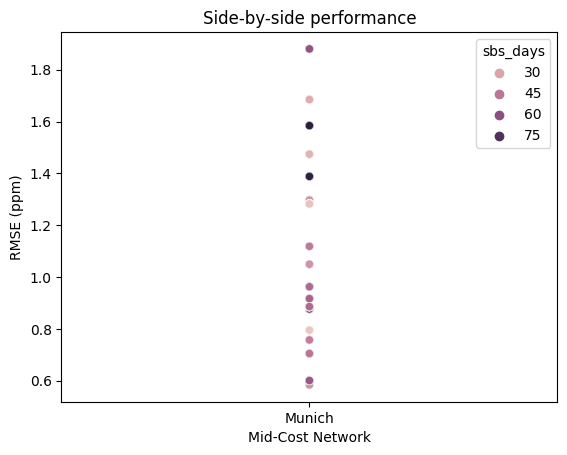

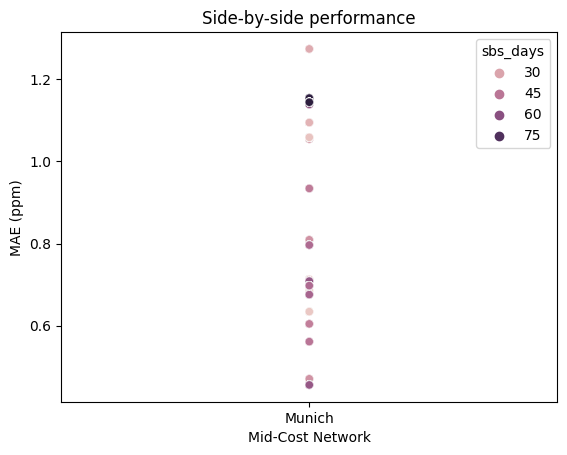

In [12]:
sns.scatterplot(data=df_plot,x='Mid-Cost Network',y='RMSE (ppm)', hue="sbs_days", alpha=0.5).set(title='Side-by-side performance')
plt.show()

sns.scatterplot(data=df_plot,x='Mid-Cost Network',y='MAE (ppm)', hue="sbs_days", alpha=0.5).set(title='Side-by-side performance')
plt.show()